# 프로젝트: 한영 번역기 만들기

## 목차
1. 데이터 불러오기, 전처리, 모델 빌딩, 학습하기 평가하기 
- 참고자료의 내용을 대부분 참고하였다.
2. 데이터를 뜯어보자.
- 학습결과 성능이 좋지 않은데, 다수의 데이터 샘플을 살펴보고 문제점을 찾고자 했다.

# 1. 

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
import random

print(tf.__version__)

2.6.0


In [3]:
file_path = os.getenv('HOME')+'/aiffel/s2s_translation'
print(file_path)

/aiffel/aiffel/s2s_translation


In [4]:
def load_file(file_name):
    with open(file_path+'/{}'.format(file_name), "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")

    for sen in raw[0:100][::20]: 
        print(">>", sen)
    
    return raw

In [5]:
raw_kor = load_file('korean-english-park.train.ko')
raw_kor += load_file('korean-english-park.dev.ko')
raw_kor += load_file('korean-english-park.test.ko')
print('total data size:', len(raw_kor))

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data Size: 1000
Example:
>> 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> 그는 눈에 띄지 않게 행동하는 것으로 알려져있다. 그는 영국 시사잡지 타임즈에서 “파티에 잘 참석하지 않는다”며 자신의 생활에 대한 날조된 이야기를 즐기고 있다.
Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 수입

In [6]:
raw_en = load_file('korean-english-park.train.en')
raw_en += load_file('korean-english-park.dev.en')
raw_en += load_file('korean-english-park.test.en')
print('total data size:', len(raw_en))


Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
Data Size: 1000
Example:
>> After keeping the world's most powerful supercomputer to themselves for a year, government researchers showed off the $110 million wonder and said it might help save the world from nuclear war.
>> The head of the U.N. weapons inspection

In [10]:
print('korean data size:', len(raw_kor))
print('english data size:', len(raw_en))

korean data size: 97123
english data size: 97123


In [11]:
raw = zip(raw_kor, raw_en)
raw


In [12]:
set_raw = set(raw)


In [13]:
len(set_raw)


81959

In [14]:
cleaned_corpus_kor, cleaned_corpus_eng = zip(*set_raw)


In [15]:
print('korean data size:', len(cleaned_corpus_kor))
print('english data size:', len(cleaned_corpus_eng))

korean data size: 81959
english data size: 81959


In [17]:
print(cleaned_corpus_kor[100])
print(cleaned_corpus_eng[100])


현재 러시아는 NATO의 동진(東晉)을 막기 위해 우크라이나와 그루지야의 NATO가입을 완강히 반대하고 있다.
Russia opposes NATO membership for Ukraine and Georgia, concerned that the alliance's eastward march will erode its influence in those countries.


In [18]:
# 전처리 토큰추가
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [19]:
for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    print(kor, eng)
    break

라이스 장관은 “최근 이라크군이 용감하게 반군과 대응해 성공적으로 진압했다”며 “이를 이끌어낸 이라크 지도자들의 결정과 실행한 이라크 보안군에게 감사의 마음을 전한다”고 말했다. ¡°It is indeed a moment of opportunity in Iraq thanks to the courageous decisions taken by the prime minister and a unified Iraqi leadership,¡± Rice said Sunday. She praised ¡°the Iraqi security forces which have fought very bravely in this recent operation.


In [20]:
enc_corpus = []
dec_corpus = []

# num_examples = 30000
cnt=0
for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng, s_token=True, e_token=True)

    if len(temp_kor) <= 40:
        enc_corpus.append(temp_kor)
        dec_corpus.append(temp_eng)
    
print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[500])   
print("English:", dec_corpus[500])  

korean data size: 17055
english data size: 17055
Korean: 멜븐 샴페인 년
English: <start> firefighter melven champaign years <end>


# 문장길이 40으로 자르고 나니 17055개 가 남는다

In [21]:
print("Korean:", enc_corpus[100])   
print("English:", dec_corpus[100]) 

Korean: 크랜리는 일간의 구류를 선고받고 수감돼있다 .
English: <start> cranley has served nearly days in custody . <end>


In [23]:
print("Korean:", cleaned_corpus_kor[100])   
print("English:", cleaned_corpus_eng[100])  

Korean: 현재 러시아는 NATO의 동진(東晉)을 막기 위해 우크라이나와 그루지야의 NATO가입을 완강히 반대하고 있다.
English: Russia opposes NATO membership for Ukraine and Georgia, concerned that the alliance's eastward march will erode its influence in those countries.


In [25]:
from konlpy.tag import Mecab

vocab_size = 50000
def tokenize(corpus, kor=False, eng=True):
    if kor:
        mecab = Mecab()
        morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(morph)

        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    if eng:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [26]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus, kor=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, eng=True)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 41796
English Vocab Size: 17325


In [27]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [28]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [29]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [30]:

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 17326)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


In [32]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [33]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss

# Training Process

from tqdm import tqdm

EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 30: 100%|██████████| 54/54 [00:02<00:00, 18.53it/s, Test Loss 1.4060]


In [41]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder, plot = True):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    if plot:
        
        attention = attention[:len(result.split()), :len(sentence.split())]
        plot_attention(attention, sentence.split(), result.split(' '))

Input: 집에 가는 길은 이쪽입니다 .
Predicted translation: but it . <end> 


/tmp/ipykernel_48/3857991053.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/3857991053.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


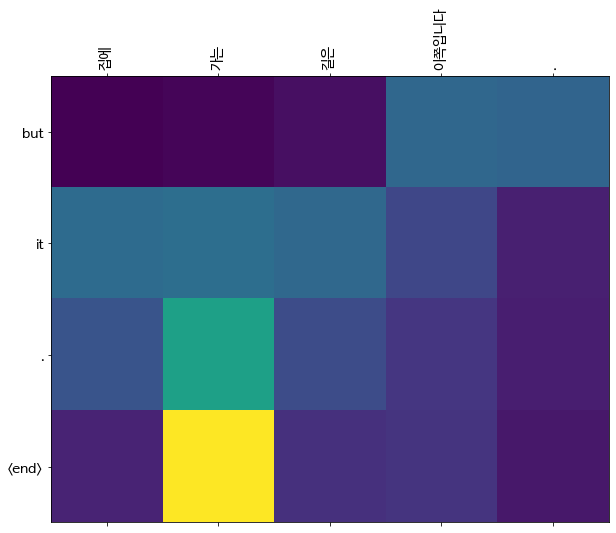

In [44]:
translate("집에 가는 길은 이쪽입니다.", encoder, decoder)

Input: 개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?
Predicted translation: they had been hospitalized for the same areas which is a long lines in the same areas which is a long lines in the same areas which is a long lines in the same areas which is a long lines in the same areas which is a long lines in the same areas which is a long lines in the same areas which is a long lines 


/tmp/ipykernel_48/3857991053.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/3857991053.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


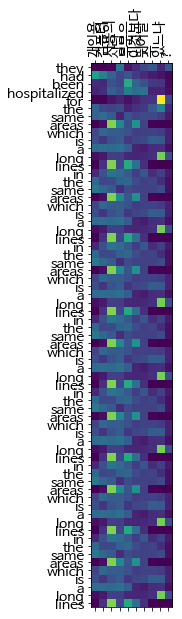

In [45]:
translate("개인용 컴퓨터 사용의 상당 부분은 \'이것보다 뛰어날 수 있느냐?'", encoder, decoder)

Input: 불과 년 전이다 .
Predicted translation: that s not be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be 


/tmp/ipykernel_48/3857991053.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/3857991053.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


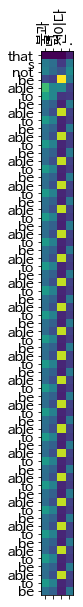

In [46]:
translate("불과 1,379년 전이다.", encoder, decoder)

Input: 오바마는 대통령이다 .
Predicted translation: obama s . <end> 


/tmp/ipykernel_48/3857991053.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/3857991053.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


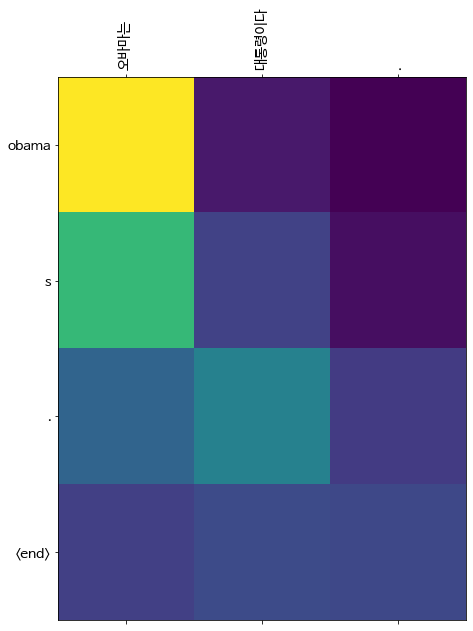

In [47]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: los angeles . <end> 


/tmp/ipykernel_48/3857991053.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/3857991053.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


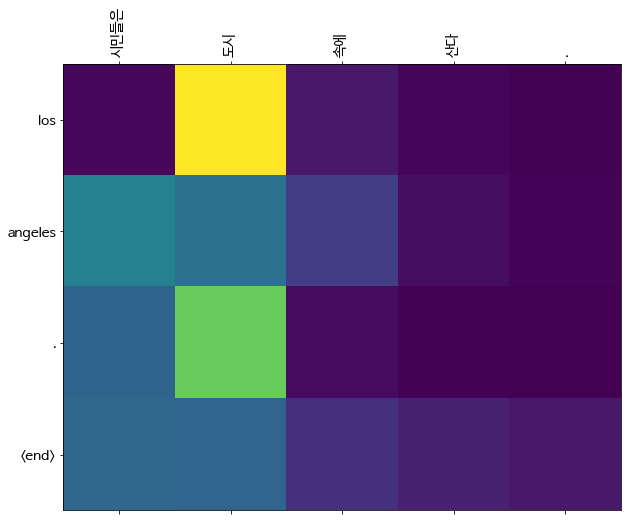

In [48]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: the city . <end> 


/tmp/ipykernel_48/3857991053.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/3857991053.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


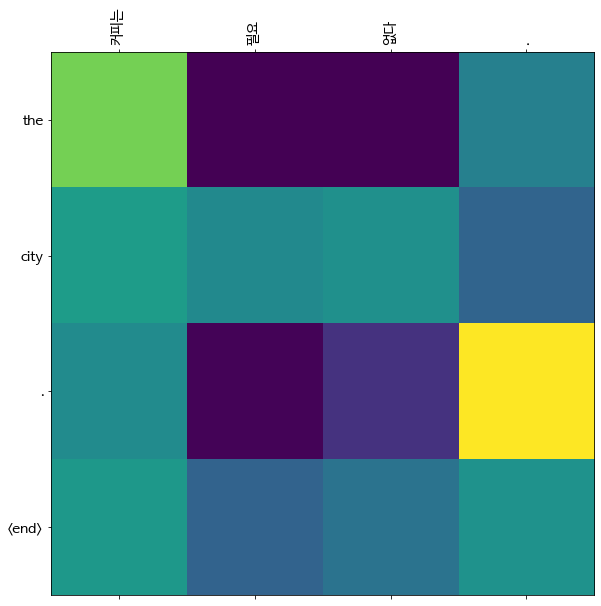

In [49]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: hundreds of the u . s . percent . <end> 


/tmp/ipykernel_48/3857991053.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/3857991053.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


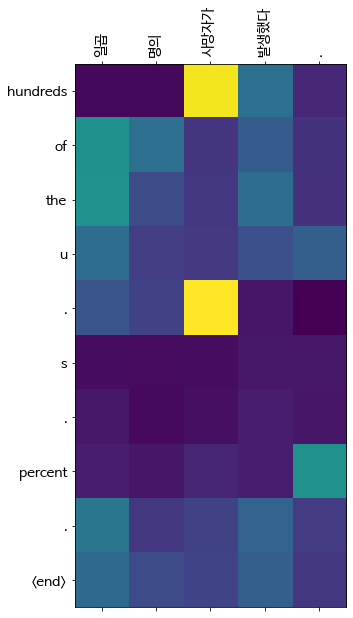

In [50]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

In [54]:
translate("오바마는 대통령이다.", encoder, decoder, plot = False)
translate("시민들은 도시 속에 산다.", encoder, decoder, plot = False)
translate("커피는 필요 없다.", encoder, decoder, plot = False)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder, plot = False)

Input: 오바마는 대통령이다 .
Predicted translation: obama s . <end> 
Input: 시민들은 도시 속에 산다 .
Predicted translation: los angeles . <end> 
Input: 커피는 필요 없다 .
Predicted translation: the city . <end> 
Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: hundreds of the u . s . percent . <end> 


# 2. -
# 해석문이 깔끔하지 않다.
# 앞에서 확인 했듯이 데이터에서 한글과 번역이 틀린부분이 더러 있는것 같다. 일일이 확인해주고 정제해주어야 할것이다.

In [ ]:

print("Korean:", enc_corpus[100])   
print("English:", dec_corpus[100]) 

In [56]:
print(len(enc_corpus))
print(len(dec_corpus))

17055
17055


In [67]:
filtered_enc_corpus = []
filtered_dec_corpus = []
wrong_enc_corpus = []
wrong_dec_corpus = []


c = 0
for kor, eng in zip(enc_corpus, dec_corpus):
    print('---'*7)
    print(c, '번째')
    print('kor\n', kor)
    print('eng\n', eng)
    x = input('y/n?:')
    if x =='y':
        filtered_enc_corpus.append(kor)
        filtered_dec_corpus.append(eng)
            
    elif x == 'n':
        wrong_enc_corpus.append(kor)
        wrong_dec_corpus.append(eng)
            
    else:
        pass
    c += 1

---------------------
0 번째
kor
 oxford england cnn 이수지 joins
eng
 <start> commonly referred to as oxbridge <end>
y/n?:n
---------------------
1 번째
kor
 정말로 매혹적인 것은 하나의 동물을 하나의 생명체를 얻을 수
eng
 <start> the creatures are independent of the player ? <end>
y/n?:n
---------------------
2 번째
kor
 어휘
eng
 <start> a study by australia s main scientific body found high levels of toxic emissions in cars for up to six months and longer after they leave the showroom . <end>
y/n?:n
---------------------
3 번째
kor
 최근 미 중서부 지역에는 기록적인 강수량과 홍수로 최소 명이 사망했다 .
eng
 <start> the governor wants the federal government to declare a major disaster in the parts of north central ohio inundated by the past week s powerful storms and record floods that were blamed for at least deaths in the midwest . <end>
y/n?:y
---------------------
4 번째
kor
 그는 우리 모두 해들리의 목소리를 다시 듣고 싶어한다 고 덧붙였다 .
eng
 <start> he was noticed in the late s by beverly sills then general director of the new york city opera which hired him . <end>
y/n?

KeyboardInterrupt: Interrupted by user

In [68]:
print(len(filtered_enc_corpus))
print(len(filtered_dec_corpus))
print(len(wrong_enc_corpus))
print(len(wrong_dec_corpus))

64
64
35
35


In [71]:
for i in range(len(wrong_dec_corpus)):
    print('----'*7)
    print(i,'번째')
    print('|',wrong_enc_corpus[i],"|",wrong_dec_corpus[i],'|')

----------------------------
0 번째
| oxford england cnn 이수지 joins | <start> commonly referred to as oxbridge <end> |
----------------------------
1 번째
| 정말로 매혹적인 것은 하나의 동물을 하나의 생명체를 얻을 수 | <start> the creatures are independent of the player ? <end> |
----------------------------
2 번째
| 어휘 | <start> a study by australia s main scientific body found high levels of toxic emissions in cars for up to six months and longer after they leave the showroom . <end> |
----------------------------
3 번째
| 그는 우리 모두 해들리의 목소리를 다시 듣고 싶어한다 고 덧붙였다 . | <start> he was noticed in the late s by beverly sills then general director of the new york city opera which hired him . <end> |
----------------------------
4 번째
| attempt 을 시도 기도 하다 꾀하다 기획하다 | <start> a right wing japanese politician has attempted to justify plans to fingerprint foreigners by claiming he knows an al qaeda member who entered the country illegally . <end> |
----------------------------
5 번째
| thwart 저지하다 좌절시키다 | <start> elsewhere police there

# 실제로 100개 가량의 데이터를 살펴보고 하나하나 번역이 맞는지 분류해 보았다.
## 그중 35개의 문장의 한글과 영어 데이터쌍이 잘못 레이블된 데이터였다. 전체 데이터중 약 35%의 오류가 있는 것이다.
### 오류의 종류는 다음과 같다.
__뉴스 기사,크롤링__

|한글|번역|
|------|---|
|oxford england cnn 이수지 joins|commonly referred to as oxbridge|
|기사공유|he was wrong about those .|
| new york cnn 김양희 joins | <start> this material may not be published . <end> |
    | 원문기사보기 | <start> to persuade another company to produce the instant film . <end> |
    | . . 입력 . . 수정 | <start> but we have a long way to go to figure out the implications of it . <end> |

__사전, 예문(?)__

|한글|번역|
|------|---|
| 어휘 | <start> a study by australia s main scientific body found high levels of toxic emissions in cars for up to six months and longer after they leave the showroom . <end> |
| attempt 을 시도 기도 하다 꾀하다 기획하다 | <start> a right wing japanese politician has attempted to justify plans to fingerprint foreigners by claiming he knows an al qaeda member who entered the country illegally . <end> |
| thwart 저지하다 좌절시키다 | <start> elsewhere police there thwarted a suicide bombing . <end> |
| appearance 출현 출두 출연 등장 | <start> hawking had canceled an appearance at arizona state university on april because of his illness . <end> |
    | predecessor 전임자 | <start> rudd said he would overturn a number of his predecessor s policies including signing the kyoto protocol and pulling troops out of iraq . <end> |
    | impeachment trial 탄핵 재판 | <start> on nbc s today show blagojevich says he s boycotting today s start of his impeachment trial before the state senate because it won t be fair <end> |
    | 영한사전 약어표 한영사전 약어표 | <start> in a related development ellen r . sauerbrey u . s . assistant secretary for the bureau of population refugees and migration in the state department will visit thailand next week to discuss the issue of north korean refugees radio free asia rfa reported . <end> |
| ultimately 궁극적으로 최후로 | <start> sohn said in principle he agrees the people will be the beneficiaries of the deal ultimately but added there are some obstacles to the parliamentary ratification . <end> |
| tenant 거주자 주민 | <start> a landlord is promising months free rent if his apartment tenants in ohio florida north carolina and texas lose their jobs . <end> |
    | judicial 사법의 재판관의 분석적인 공정한 천벌의 | <start> the commission s report came a day after a un envoy accused the army of being in denial over the issue of extra judicial killings . <end> |
    | spree 몰두 탐닉 | <start> he then went on a shooting spree . <end> |
    | drop in traffic death 년 교통사고 사망률 감소 . | <start> getting back to traffic <end> |
    | hanukah 유대교의 성전헌당기념일 | <start> the obamas are scheduled to spend twelve days in hawaii . <end> |
    
__오역, 의역__
    
|한글|번역|
|------|---|
|정말로 매혹적인 것은 하나의 동물을 하나의 생명체를 얻을 수|commonly referred to as oxbridge|
| 그는 우리 모두 해들리의 목소리를 다시 듣고 싶어한다 고 덧붙였다 . | <start> he was noticed in the late s by beverly sills then general director of the new york city opera which hired him . <end> |
    | 비행기니 . . 틸트로터 헬기니 ? | <start> i might play two in a row three in a row and have some momentum . <end> |
    | 과연 호머 마지 바트 리사 마기 심슨에게도 비슷한 일이 벌어질까요 ? | <start> everybody or almost everybody who ran the show or was there at the beginning took part in the first meeting for the movie brooks said . <end> |
    | 에게 발언권을 인정하다 주다 . | <start> all rights reserved . <end> |
    | 아베 총리의 발언은 년 발견된 일본 자료의 증거를 부정한 것이다 . | <start> many victims say they were kidnapped and forced into sexual slavery by japanese troops . <end> |
    | 이바노비치는 그랜드슬램 결승전에 진출한 첫번째 세르비아 선수가 됐다 . | <start> i knew i had to be aggressive from the beginning and that s what i tried to do said ivanovic . <end> |
    | 온몸으로 말하는 기상캐스터 온몸으로 말하는 기상캐스터 | <start> and are unlikely to damage campaign signs again as the incident scared them . <end> |
    | 그중 몇몇 시위대는 미국에 죽음을 칼자이에 죽음을 을 외치며 항의했다 . | <start> death to karzai a reference to president hamid karzai according to the associated press . <end> |
    | 올해 월 잭은 텍사스에 있는 호수에서 열리는 여름캠프에 다녀왔다 . | <start> cnn in august jack returned from summer camp that included swims in texas lake lbj . <end> |
    | 개헌안은 월 일 국민투표를 거쳐 최종 승인된다 . | <start> to take effect the reforms must be approved by voters in a december referendum . <end> |
    | nasa 우주에서 수업하실 선생님 모십니다 | <start> astronaut teachers to inspire next generation <end> |
    | 새 방송국이 탄생하면 정부가 개입하려 할 염려가 있다 . | <start> the fear is that the new entity would be a government mouthpiece . <end> |
| 잠시 후 이란어 정부 방송에서 더빙되지 않은 영어 방송이 방영됐다 . | <start> a short time later a version with sound and in english appeared on a different government run channel that broadcasts in farsi . <end> |
    | 사건 현장을 방문한 그는 사고 원인이 업무 태만일 가능성을 일축했다 . | <start> australia s downer who attended the scene of the crash dismissed concerns that the cause of the crash was sabotage . <end> |
    | . 여성은 건강에 있어서 지나칠 정도로 정보에 의존한다 . | <start> . women tend to over research <end> |

# 회고
- [참고자료](https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-08%5Dattention_based_seq2seq_translation.ipynb)에서도 __데이터의 신뢰도__에 의문을 제기하고 있다. 
- 실제로 다수의 샘플을 살펴본 결과. 원데이터에서 발생할수있는 오류(오역,의역) 이외에도, 기사와 사전 에서 크롤링하면서 발생할수 있는는 __데이터 수집가의 실수, 오류__ 가 다수 발견되었다.
- 1만7천 개중 100여개의 일부만 살펴보았지만 약 35%가 잘못된 데이터로 이는 매우 큰수치라 할수 있겠다.
- 실제로 이러한 데이터로 학습을 한다면 모델의 성능을 기대하지도 신뢰할 수 도 없을것이다. 즉, __garbage in garbage out__이다.
- 이러한 오류가 많을 데이터를 실무에서 받게 된다면 어떻게 할까?우선 수집단계에서 크롤링 방식의 오류를 찾아서 수정하는 한편, 오류 샘플들의 공통점을 찾아내고 최대한 제거하려고 노력해야 할것이다.
